# Funções Base

In [1]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import sklearn
%load_ext autoreload
from skimage import feature
import scipy
from skimage.filters import gabor
from skimage.filters import threshold_otsu

from skimage.filters import threshold_isodata
from skimage.morphology import erosion, disk,square, closing

from scipy import signal


In [2]:
%autoreload 2

In [3]:
#find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts - w))

def find_index(wavelenghts,w):
    return np.argmin(np.abs(wavelenghts - w))

In [4]:
def read_data_map(file):
    hf = h5py.File(file, 'r')
    spectrums = np.array(hf.get('intensities'))
    positions = np.array(hf.get('position'))
    wavelengths = np.array(hf.get('wavelengths'))
    positions = np.delete(positions, 0, 0)
    spectrums = np.delete(spectrums, 0, 0)
    x = positions[:, 0]
    y = positions[:, 1]
    xy = np.lexsort((y, x))

    hf.close()
    return spectrums[xy], wavelengths, positions

# Amostra 1

In [118]:

filename = '1.quartz_amblygonite'
def read_data_map(file):
 
    hf = h5py.File(file + '.h5', 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]
 
    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
 
   
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
   
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:, 0],positions[:, 1]))
    spectrums = spectrums[indexes, :]
    spectrums = np.array(spectrums.reshape((ny, nx, -1)))
    # print(spectrums.shape)
    positions = np.array(positions[indexes])
   
    hf.close()
    return  spectrums,positions,wavelengths


spectrum, positions,wavelengths = read_data_map(filename)

pro_data = 1*spectrum

pro_data_norm=pro_data.copy()
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        spec = 1 * pro_data[i,j, :]
        sum_spec=np.sum(spec)
        pro_data_norm[i,j,:]=spec/sum_spec
pro_data_norm=np.array(pro_data_norm)


## 1.1 Deteção de Elementos

In [119]:
print(spectrum.shape)
print(pro_data_norm.shape)

(54, 70, 16384)
(54, 70, 16384)


In [120]:
maps=pro_data_norm.copy()
wavelengths=wavelengths.flatten()

In [121]:
maps=np.transpose(maps,axes=(2,0,1))

In [122]:
el=[610.22,309.27,288.13,777.194,656.285,253.56,478.94]
el_n=['Li','Al','Si','O','H','P','F']

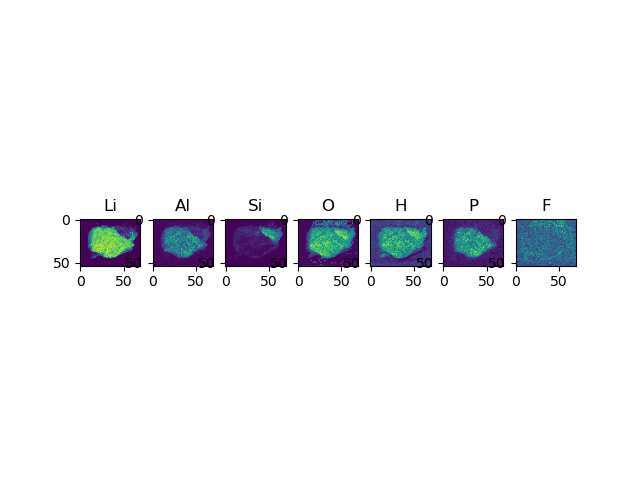

In [123]:
%matplotlib widget
fig,ax=subplots(1,len(el))
for i in range(len(el)):
    ax[i].imshow(maps[find_index(wavelengths,el[i])])
    ax[i].set_title(el_n[i])

In [124]:
normalized_spec1=np.transpose(maps.reshape(-1,maps.shape[1],maps.shape[2]),axes=(1,2,0))

nx, ny = normalized_spec1.shape[1], normalized_spec1.shape[0]
dx = 0.5
dy = 0.5
 
freqs_x = 2*np.pi*np.fft.fftfreq(nx, dx)
freqs_y = 2*np.pi*np.fft.fftfreq(ny, dy)
 
def fft_feature(mmap, pixel_size_small):
    fft_map = np.array([np.fft.fftshift(np.fft.fft2(mmap[:, :, i])) for i in tqdm(range(0, (mmap.shape[-1])))])
    fft_map[:, fft_map.shape[1]//2, fft_map.shape[2]//2] = 0
 
    kxx, kyy = np.meshgrid(np.fft.fftshift(freqs_x), np.fft.fftshift(freqs_y))
 
    object_size_small = pixel_size_small*dx
    size_kspace_small = 2*np.pi/object_size_small/2*1.5
 
    R = abs(np.sqrt(kxx**2 + kyy**2))
 
    sum1 = np.sum(np.abs(fft_map[:,(R < size_kspace_small)]), axis = (1))
    max1 = np.sum(np.abs(fft_map), axis = (1, 2))
 
    sums = np.array(sum1)/np.array(max1)
 
    return sums, fft_map
 
sums, fft_m = fft_feature(normalized_spec1, 10)

100%|██████████| 16384/16384 [00:05<00:00, 3274.40it/s]


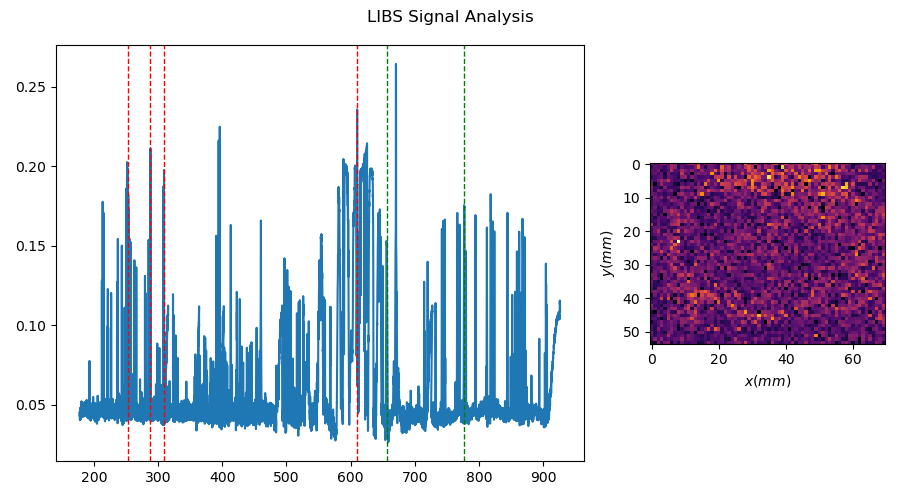

In [125]:
el=[610.22,309.27,288.13,253.56]
el_n=['Li','Al','Si','P','F']

extra=[777.194,656.285]

find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))
    
%matplotlib widget
fig, ax = subplots(1,2, figsize = (9, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('LIBS Signal Analysis')

axs = ax[0]
axs.plot(wavelengths,sums)
for i in range(len(el)):
    axs.axvline(el[i],linestyle='--',color='red',lw=1)
for j in range(len(extra)):
    axs.axvline(extra[j],linestyle='--',color='green',lw=1)
axs = ax[1]
axs.imshow(maps[100,:, :], cmap = cm.inferno)
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')



def update_map(wn):
    im = ax[1].imshow(maps[wn,:, :],
                     interpolation = 'none')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths, ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

In [126]:
peaks=scipy.signal.find_peaks(sums)[0]
sel_maps=[]
sel_wavs=[]
heights=sums[peaks]
for i in range(len(peaks)):
    if heights[i]>0.174:
        sel_maps.append(maps[peaks[i]])
        sel_wavs.append([wavelengths[peaks[i]]])

sel_maps=np.array(sel_maps)
sel_maps=sel_maps.reshape(-1,maps.shape[1],maps.shape[2])

In [127]:
sel_wavs=np.array(sel_wavs)
sel_wavs

array([[213.55522156],
       [250.57090759],
       [251.3298645 ],
       [251.48745728],
       [252.30404663],
       [252.741745  ],
       [251.38937378],
       [251.58334351],
       [251.89335632],
       [252.35765076],
       [252.82099915],
       [253.51435852],
       [288.12942505],
       [308.17245483],
       [309.22097778],
       [394.23461914],
       [394.28546143],
       [394.33624268],
       [395.98110962],
       [396.02905273],
       [396.09280396],
       [581.06237793],
       [581.30993652],
       [581.4954834 ],
       [581.86621094],
       [582.17474365],
       [582.42126465],
       [588.86676025],
       [589.46606445],
       [590.83868408],
       [591.07653809],
       [591.25476074],
       [591.43292236],
       [591.55151367],
       [591.67016602],
       [591.90716553],
       [592.02563477],
       [592.203125  ],
       [592.32141113],
       [592.55773926],
       [592.67584229],
       [592.79388428],
       [593.02972412],
       [593

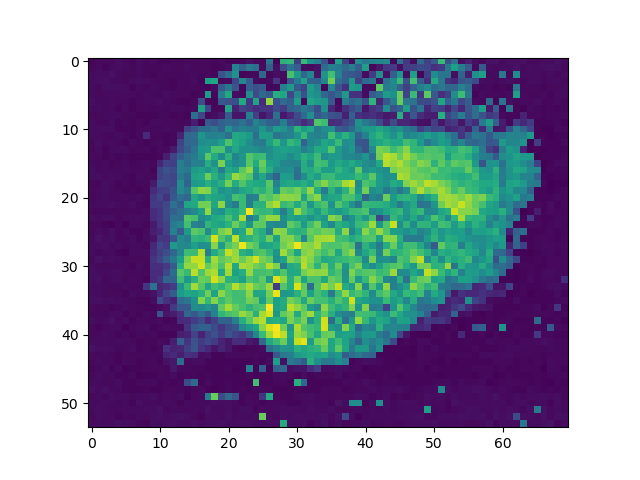

In [128]:
plt.figure()
plt.imshow(maps[find_index(wavelengths,777)])

In [129]:
# para os mapas que estão dentro dos parametros da fft retirar os que tem sinal fora da rocha
sel_maps_f=sel_maps.reshape(-1,sel_maps.shape[1]*sel_maps.shape[2])
thresholds=np.array([threshold_otsu(sel_maps_f[i]) for i in range(sel_maps.shape[0])])
final_masks=[]
for map in range(len(thresholds)):
    c_mask=np.zeros(sel_maps_f.shape[1])
    for i in range(sel_maps_f.shape[1]):
        if sel_maps_f[map,i]>thresholds[map]:
            c_mask[i]=1
    final_masks.append(c_mask)

final_masks=np.array(final_masks).reshape(-1,sel_maps.shape[1],sel_maps.shape[2])


new_maps=[]
edge=[]
new_wavs=[]
#ajustar regiao fora do mapa
for w in tqdm(range(final_masks.shape[0])):
    current_map=final_masks[w,:,:]
    pixel_sum=np.sum(current_map[40:,50:])+np.sum(current_map[40:,:20])
    if pixel_sum <5:
        new_maps.append(sel_maps[w,:,:])
        new_wavs.append(sel_wavs[w])
new_maps=np.array(new_maps)
print(sel_maps.shape)
print(new_maps.shape)

100%|██████████| 151/151 [00:00<?, ?it/s]

(151, 54, 70)
(17, 54, 70)


In [130]:
new_wavs

[array([213.55522156]),
 array([250.57090759]),
 array([251.3298645]),
 array([251.48745728]),
 array([252.30404663]),
 array([251.38937378]),
 array([251.58334351]),
 array([251.89335632]),
 array([252.35765076]),
 array([252.82099915]),
 array([253.51435852]),
 array([288.12942505]),
 array([308.17245483]),
 array([309.22097778]),
 array([610.22436523]),
 array([670.65649414]),
 array([670.8248291])]

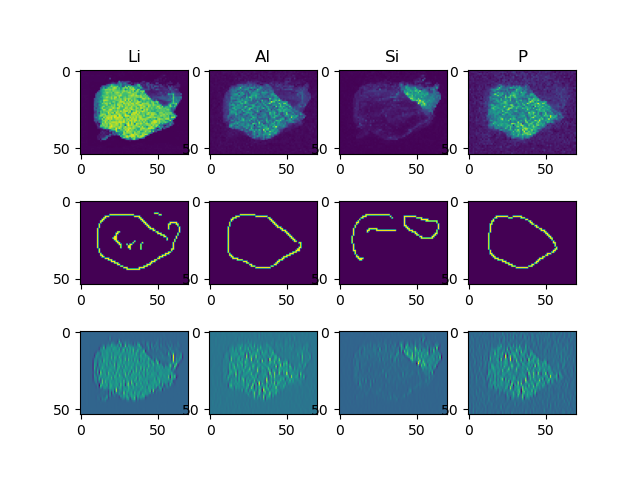

In [131]:
fig,ax=subplots(3,len(el))
for i in range(len(el)):
    c_map=maps[find_index(wavelengths,el[i]),:,:]
    ax[0,i].imshow(c_map)
    ax[0,i].set_title(el_n[i])
    ax[1,i].imshow(feature.canny(c_map*800,sigma=3))
    ax[2,i].imshow(gabor(c_map*300, frequency=0.6)[0])

In [132]:
edge_maps=[]
for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]*800
    edges = feature.canny(current_map,sigma=3)
    edge_maps.append(edges)
edge_maps=np.array(edge_maps)
texture_maps=[]

for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]
    filt_real, filt_imag = gabor(current_map, frequency=0.6) #lower f, more sensitivty to detail
    texture_maps.append(filt_real)
texture_maps=np.array(texture_maps)


100%|██████████| 17/17 [00:00<00:00, 697.33it/s]


In [133]:
n_clusters=6
kmeans = sklearn.cluster.KMeans(n_clusters = n_clusters,random_state=0)
 
new_features=new_maps*500+edge_maps*0.3+texture_maps*200
features=new_features.reshape(-1,maps.shape[2]*maps.shape[1])
a=kmeans.fit_predict(features)
labels = kmeans.labels_
clusters_c = np.array(kmeans.cluster_centers_)

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


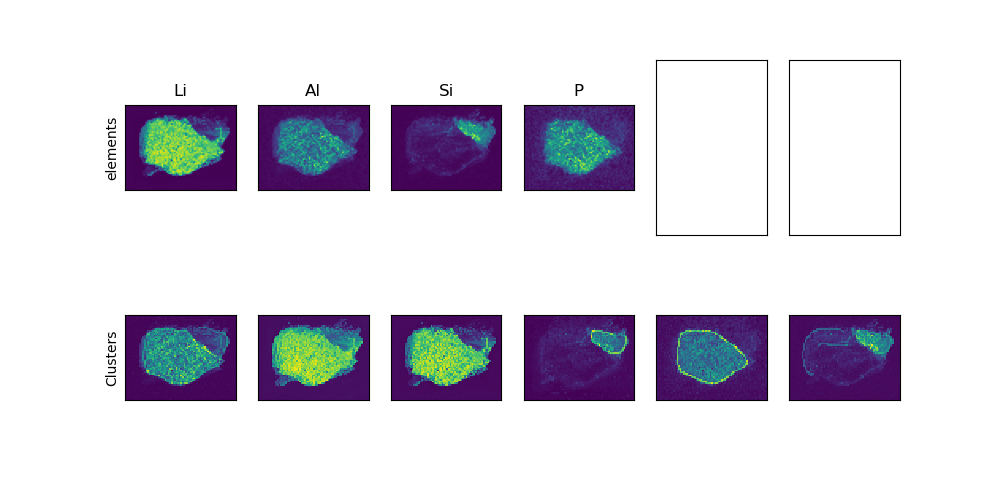

In [134]:
fig,ax=subplots(2,n_clusters,figsize=(10,5))
for i in range(n_clusters):
    if i<len(el):
        wav=find_index(wavelengths,el[i])
        ax[0,i].imshow(maps[wav,:,:])
        ax[0,i].set_title(el_n[i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0,0].set_ylabel('elements')
    ax[1,0].set_ylabel('Clusters')

    ax[1,i].imshow(clusters_c[i].reshape(maps.shape[1], maps.shape[2]), interpolation = 'none')

In [84]:
#my_labels=['O','Mg','Sample','nd','Na','K','Li','nd','Al','Ca','Si']

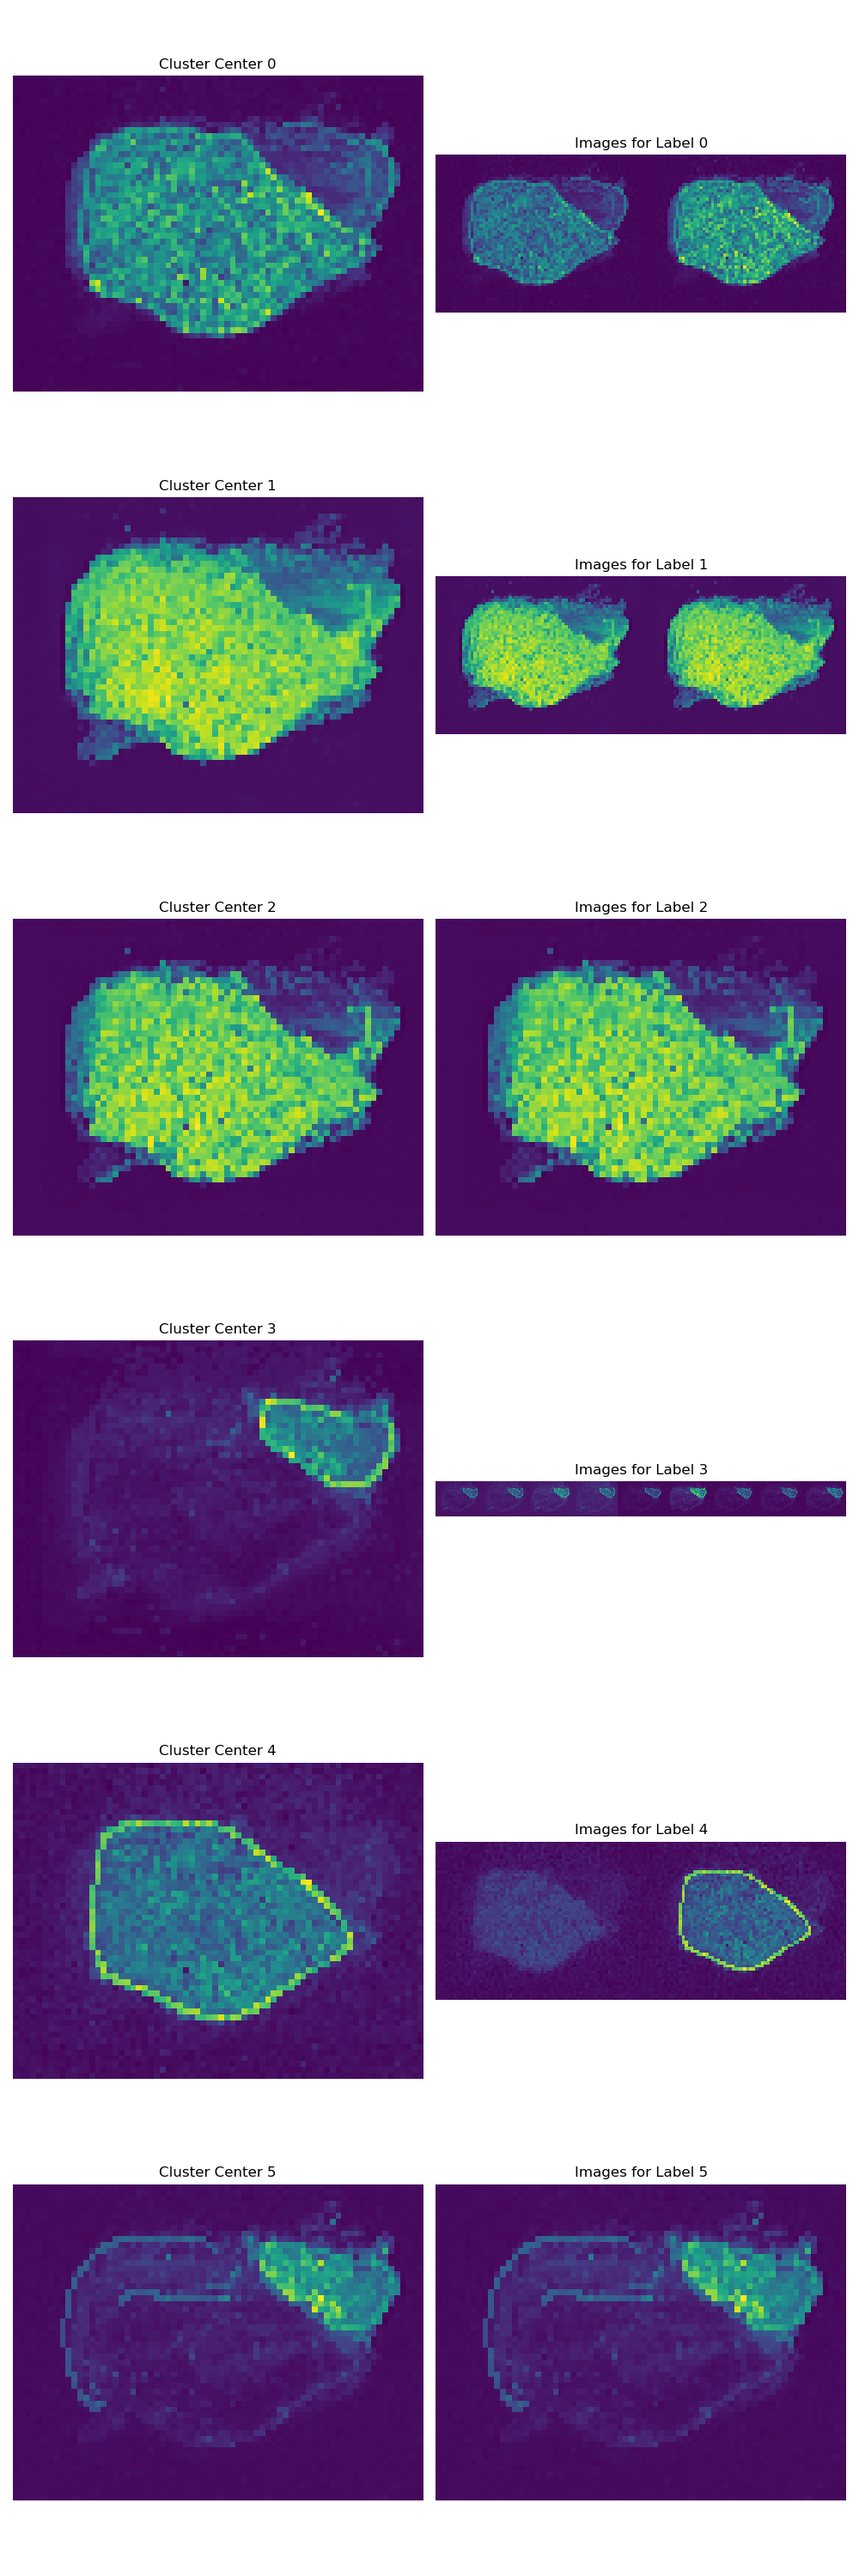

In [135]:
# verificar mapas classificados em cada cluster
import numpy as np
import matplotlib.pyplot as plt

# Assuming the following variables are defined:
# - labels: your labels array from k-means
# - clusters_c: your cluster centers array
# - features: the array of features/images used in k-means clustering
# - maps: used to determine the reshaping dimensions
%matplotlib widget
# Reshape dimensions
height, width = maps.shape[1], maps.shape[2]

# Find unique labels
unique_labels = np.unique(labels)

# Create subplots with enough space to visualize
fig, ax = plt.subplots(len(unique_labels), 2, figsize=(10, 5 * len(unique_labels)))

for i, label in enumerate(unique_labels):
    # Display the cluster center
    ax[i, 0].imshow(clusters_c[label].reshape(height, width), interpolation='none')
    ax[i, 0].set_title(f'Cluster Center {label}')
    ax[i, 0].axis('off')

    # Collect and display all images corresponding to this label
    label_indices = np.where(labels == label)[0]
    all_features = [features[idx].reshape(height, width) for idx in label_indices]
    
    # Display images
    combined_image = np.concatenate(all_features, axis=1)  # Combine images side by side
    ax[i, 1].imshow(combined_image, interpolation='none')
    ax[i, 1].set_title(f'Images for Label {label}')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [136]:
# obter comprimentos de onda dos mapas classificados em cada cluster

height, width = maps.shape[1], maps.shape[2]

unique_labels = np.unique(labels)



for i, label in enumerate(unique_labels):
    label_indices = np.where(labels == label)[0]
    all_wavs = [new_wavs[idx][0] for idx in label_indices]
    
    print('cluster', i, '\n')
    print('wavelengths:', all_wavs, '\n')




cluster 0 

wavelengths: [308.1724548339844, 309.2209777832031] 

cluster 1 

wavelengths: [670.656494140625, 670.8248291015625] 

cluster 2 

wavelengths: [610.224365234375] 

cluster 3 

wavelengths: [250.57090759277344, 251.32986450195312, 251.48745727539062, 252.30404663085938, 251.38937377929688, 251.58334350585938, 251.8933563232422, 252.35765075683594, 252.8209991455078] 

cluster 4 

wavelengths: [213.5552215576172, 253.5143585205078] 

cluster 5 

wavelengths: [288.1294250488281] 



In [137]:
from AnalysisTools.analysis import AnalyticsToolkit
toolkit=AnalyticsToolkit()
emission_database=toolkit.process_database(ion_num=1)

In [138]:
database_lines=emission_database[:,2]
database_elements=emission_database[:,0]

In [139]:
np.unique(database_elements)

array(['Al', 'C', 'Ca', 'Co', 'Cr', 'Cu', 'Fe', 'K', 'Li', 'Mg', 'Mn',
       'Na', 'O', 'P', 'Pb', 'Rb', 'Si', 'Ti', 'Zn'], dtype=object)

In [140]:
elements_of_cluster = []
counts=[]

sample_xmin=10
sample_xmax=40
sample_ymin=10
sample_ymax=60

def find_index(wavelengths, target_wavelength):
    return np.abs(wavelengths - target_wavelength).argmin()

def calculate_intersection(map1, map2):
    return np.sum((map1 > 0) & (map2 > 0))

for i, label in enumerate(unique_labels):

    label_indices = np.where(labels == label)[0]
    all_wavs = [new_wavs[idx][0] for idx in label_indices]
    indexes = [np.abs(database_lines - wav).argmin() for wav in all_wavs]
    elements = database_elements[indexes]
    element_counts = Counter(elements)

    unique_elements = np.unique(elements)
    intersections = {}

    # Calculate intersection for all unique elements
    for element in unique_elements:
        element_indices = np.where(database_elements == element)[0]
        total_intersection = 0
        for el_idx in element_indices:
            ref_wavelength_index = find_index(wavelengths, database_lines[el_idx])
            ref_map = spectrum[:, :, ref_wavelength_index]
            ref_threshold = threshold_otsu(ref_map[sample_xmin:sample_xmax, sample_ymin:sample_ymax])
            ref_binary_map = ref_map > ref_threshold

            for idx in label_indices:
                map_to_compare = new_maps[idx]
                map_threshold = threshold_otsu(map_to_compare[sample_xmin:sample_xmax, sample_ymin:sample_ymax])
                map_binary = map_to_compare > map_threshold
                total_intersection += calculate_intersection(ref_binary_map, map_binary)

        avg_intersection = total_intersection / len(element_indices)
        intersections[element] = avg_intersection

    # Case when there is only one unique element
    if len(unique_elements) == 1:
        most_common_element = unique_elements[0]
        # Only proceed if the avg_intersection is above the threshold
        avg_intersection = intersections[most_common_element]
        ref_wavelength_index = find_index(wavelengths, database_lines[element_indices[0]])  # Use an index from element_indices
        ref_map = spectrum[:, :, ref_wavelength_index]
        ref_threshold = threshold_otsu(ref_map[sample_xmin:sample_xmax, sample_ymin:sample_ymax])
        ref_binary_map = ref_map > ref_threshold

        if avg_intersection / np.sum(map_binary) < 0.3:
            # Skip this element if intersection is too low
            elements_of_cluster.append('None')
            counts.append(0)
            continue

        count = avg_intersection
    else:
        # Case with multiple unique elements
        most_common_element = max(intersections, key=intersections.get)
        count = intersections[most_common_element]

    print('cluster', i)
    print('elements of closest values:', elements, '\n')
    print('most common element:', most_common_element, 'with intersection count:', count, '\n')
    elements_of_cluster.append(most_common_element)
    counts.append(count)

cluster 0
elements of closest values: ['Al' 'Al'] 

most common element: Al with intersection count: 1050.090909090909 

cluster 1
elements of closest values: ['Li' 'Li'] 

most common element: Li with intersection count: 1188.0 

cluster 3
elements of closest values: ['Si' 'Si' 'Si' 'Fe' 'Si' 'Si' 'Si' 'Si' 'Ti'] 

most common element: Si with intersection count: 1371.1 

cluster 4
elements of closest values: ['Fe' 'P'] 

most common element: P with intersection count: 1255.0 

cluster 5
elements of closest values: ['Si'] 

most common element: Si with intersection count: 155.0 



In [141]:
print(elements_of_cluster)
print(counts)

['Al', 'Li', 'None', 'Si', 'P', 'Si']
[1050.090909090909, 1188.0, 0, 1371.1, 1255.0, 155.0]


In [142]:
elements_unique = []
clusters_unique = []
counts_unique = []

for i in range(len(elements_of_cluster)):
    if elements_of_cluster[i] == 'None':
        continue
    if elements_of_cluster[i] not in elements_unique:
        elements_unique.append(elements_of_cluster[i])
        clusters_unique.append(clusters_c[i])
        counts_unique.append(counts[i])
    else:
        index = elements_unique.index(elements_of_cluster[i])
        if counts[i] > counts_unique[index]:
            clusters_unique[index] = clusters_c[i]
            counts_unique[index] = counts[i]

elements_unique = np.array(elements_unique)
clusters_unique = np.array(clusters_unique)
counts_unique = np.array(counts_unique)


In [143]:
elements_unique

array(['Al', 'Li', 'Si', 'P'], dtype='<U2')

In [144]:
clusters_unique.shape

(4, 3780)

## 1.2 Minerais

In [145]:
print(elements_of_cluster)
print(elements_unique)

['Al', 'Li', 'None', 'Si', 'P', 'Si']
['Al' 'Li' 'Si' 'P']


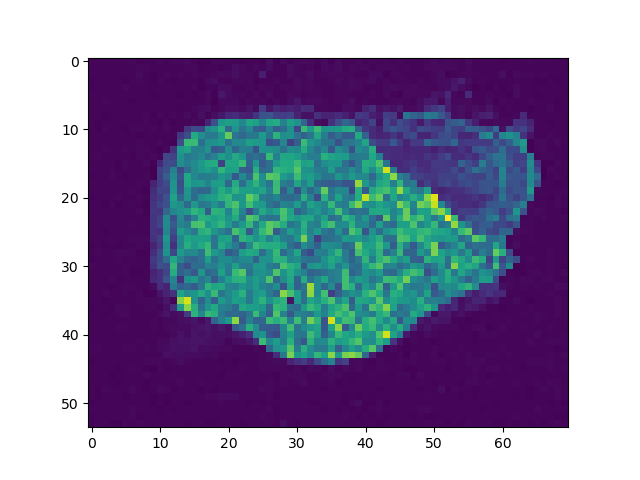

In [146]:
#definir area da imagem para thresholding
#cluster_label=['Al','Na','Si','O','Li']
cluster_label=elements_unique
clusters_reshaped=clusters_unique.reshape(-1,maps.shape[1], maps.shape[2])
plt.figure()
plt.imshow(clusters_reshaped[0])


In [147]:
clusters_reshaped.shape

(4, 54, 70)

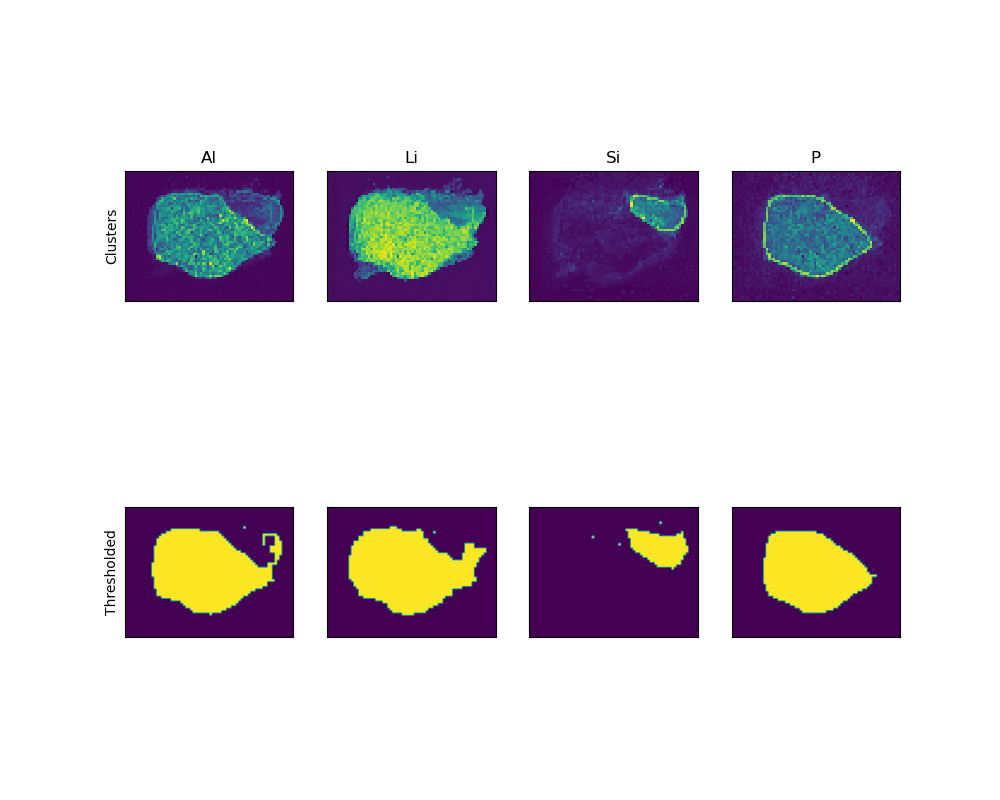

In [166]:

fig,ax=subplots(2,len(elements_unique),figsize=(10,8))
thresholded_clusters=[]

for i in range(len(elements_unique)):
    ax[0,i].imshow(clusters_reshaped[i], interpolation = 'none')
    ax[0,i].set_title(cluster_label[i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0,0].set_ylabel('Clusters')


    t=threshold_otsu(clusters_reshaped[i,sample_xmin:sample_xmax,sample_ymin:sample_ymax])# a threshold tem de ser definida só dentro da amostra
    cluster_t=clusters_reshaped[i].copy()>t
    cleaned_map = erosion(cluster_t, square(1))
    cleaned_map = closing(cleaned_map, square(4))  # disk(2) or other sizes
    thresholded_clusters.append(cleaned_map)
    ax[1,i].imshow(cleaned_map)


    ax[1,0].set_ylabel('Thresholded')
thresholded_clusters=np.array(thresholded_clusters)

In [167]:
#todos os mapas sem background
sel_maps=maps

sel_maps_f=sel_maps.reshape(-1,sel_maps.shape[1]*sel_maps.shape[2])
thresholds=np.array([threshold_otsu(sel_maps_f[i]) for i in range(sel_maps.shape[0])])
final_masks=[]
for map in range(len(thresholds)):
    c_mask=np.zeros(sel_maps_f.shape[1])
    for i in range(sel_maps_f.shape[1]):
        if sel_maps_f[map,i]>thresholds[map]:
            c_mask[i]=1
    final_masks.append(c_mask)

final_masks=np.array(final_masks).reshape(-1,sel_maps.shape[1],sel_maps.shape[2])


new_maps=[]
edge=[]
new_wavs=[]
for w in tqdm(range(sel_maps.shape[0])):
    current_map=final_masks[w,:,:]
    pixel_sum=np.sum(current_map[40:,50:])+np.sum(current_map[40:,:20])
    if pixel_sum <1:
        new_maps.append(sel_maps[w,:,:])
        new_wavs.append(wavelengths[w])
new_maps=np.array(new_maps)
print(sel_maps.shape)
print(new_maps.shape)

100%|██████████| 16384/16384 [00:00<00:00, 51342.70it/s]

(16384, 54, 70)
(104, 54, 70)


In [168]:
## thresholding de todos os mapas

thresholds=np.array([threshold_otsu(new_maps[i,sample_xmin-2:sample_xmax,sample_ymin-2:sample_ymax]) for i in range(new_maps.shape[0])])
new_maps=new_maps.reshape(-1,new_maps.shape[1]*new_maps.shape[2])
maps_thres=[]
for i in range(new_maps.shape[0]):
    c_mask=np.zeros(new_maps.shape[1])
    for j in range(new_maps.shape[1]):
        if new_maps[i][j]>thresholds[i]:
            c_mask[j]=1
    maps_thres.append(c_mask)
maps_thres=np.array(maps_thres)  

In [169]:
maps_thres=maps_thres.reshape(-1,sel_maps.shape[1],sel_maps.shape[2])

In [170]:
for i in range(maps_thres.shape[0]):
    cleaned_map = erosion(maps_thres[i], square(1))
    cleaned_map = closing(cleaned_map, square(2))  # disk(2) or other sizes
    maps_thres[i]=cleaned_map
    

In [171]:
intersections_c=[]
cluster_groups=[]
for i in range(maps_thres.shape[0]):
    intersections=[]
    clusters_n=[]
    for j in range(thresholded_clusters.shape[0]):
        cont=np.sum(np.logical_and(maps_thres[i],thresholded_clusters[j]))/np.sum(maps_thres[i])
        intersections.append(cont)
        if cont>0.6:
            clusters_n.append(j)

    intersections_c.append(intersections)
    cluster_groups.append(clusters_n)
intersections_c=np.array(intersections_c)

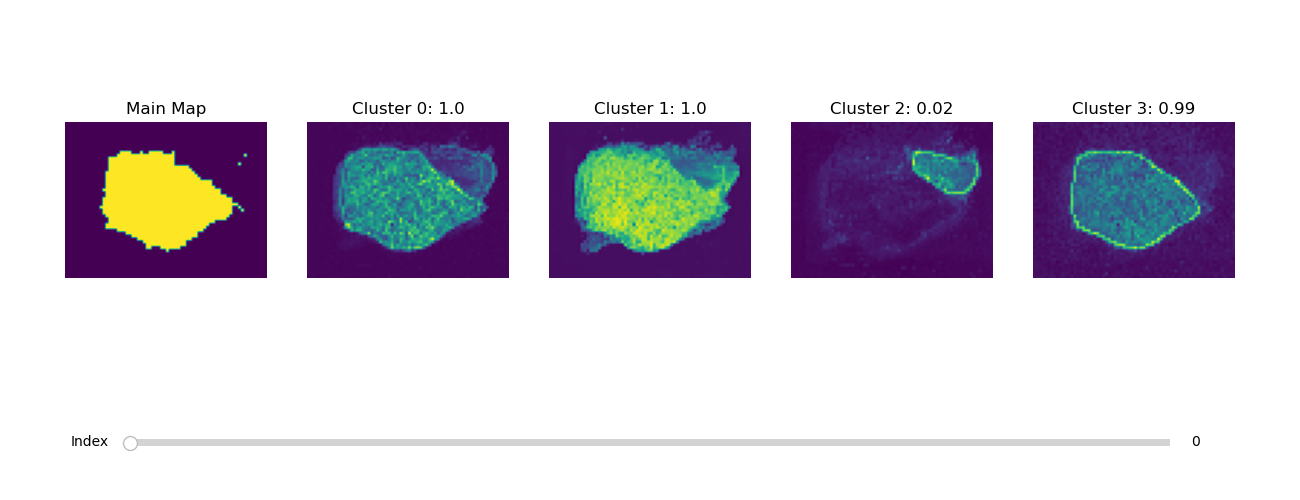

In [184]:
%matplotlib widget
# Create the figure and initial plots
fig, axes = plt.subplots(1, thresholded_clusters.shape[0] + 1, figsize=(13, 5))
plt.subplots_adjust(left=0.05, bottom=0.25, right=0.95, top=0.95)

# Plot the main new_map[i]
main_im = axes[0].imshow(maps_thres[0], cmap='viridis')
axes[0].set_title("Main Map")

# Remove x and y ticks for the main map
axes[0].axis('off')

# Plot the thresholded clusters
cluster_ims = []
for j in range(thresholded_clusters.shape[0]):
    cluster_im = axes[j + 1].imshow(clusters_reshaped[j], cmap='viridis')
    cluster_ims.append(cluster_im)
    axes[j + 1].set_title(f"Cluster {j}: {round(intersections_c[0, j],2)}")
    axes[j + 1].axis('off')  # Remove x and y ticks for each cluster plot

ax_slider = plt.axes([0.1, 0.1, 0.8, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Index', 0, maps_thres.shape[0] - 1, valinit=0, valstep=1)

def update(val):
    i = int(slider.val)
    main_im.set_data(maps_thres[i])
    
    for j, cluster_im in enumerate(cluster_ims):
        cluster_im.set_data(clusters_reshaped[j])
        axes[j + 1].set_title(f"Cluster {j}: {round(intersections_c[i, j],2)}")
    
    fig.canvas.draw_idle()

slider.on_changed(update)

plt.show()



In [173]:
from collections import defaultdict

# Create a dictionary to store unique entries and their counts
counts_dict = defaultdict(int)

for group in cluster_groups:
    counts_dict[tuple(group)] += 1

# Convert defaultdict to a regular dictionary
counts_dict = dict(counts_dict)

print(counts_dict)

{(0, 1, 3): 81, (2,): 19, (0, 1): 4}


In [174]:
# Create a new dictionary with names instead of indexes
named_counts_dict = {}

for indexes, count in counts_dict.items():
    if indexes == ():
        continue
    # Replace each index with the corresponding name from cluster_label
    else:
        named_keys = [cluster_label[index] for index in indexes]
        named_counts_dict[tuple(named_keys)] = count
sorted_items = sorted(named_counts_dict.items(), key=lambda x: x[1], reverse=True)

print(sorted_items)

[(('Al', 'Li', 'P'), 81), (('Si',), 19), (('Al', 'Li'), 4)]


In [175]:
cluster_label

array(['Al', 'Li', 'Si', 'P'], dtype='<U2')

(3, 54, 70)


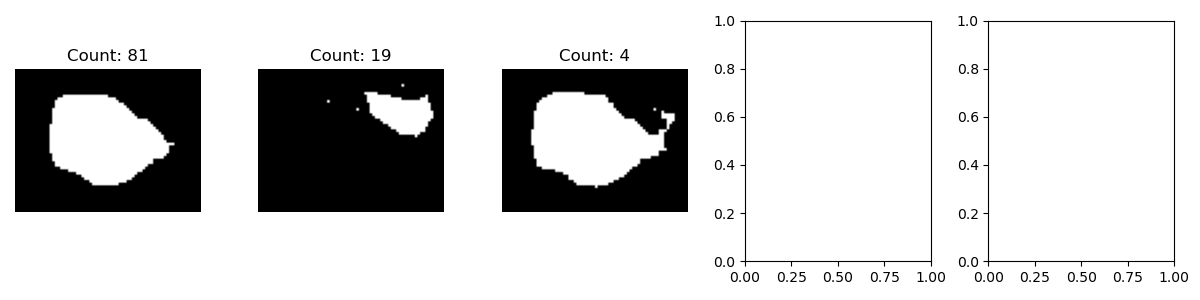

In [176]:
cluster_label_list = cluster_label.tolist()
def calculate_intersection(indices):
    # Start with the first cluster's elements
    intersection = thresholded_clusters[indices[0]]
    
    # Apply np.logical_and across the selected clusters
    for index in indices[1:]:
        intersection = np.logical_and(intersection, thresholded_clusters[index])
    
    return intersection

# Take the top 4 entries (if there are at least 4)
top_four_entries = sorted_items[:5]

# Initialize an array to store the top four intersection maps
top_four_intersections = []

# Iterate through the top four entries
for names, count in top_four_entries:
    # Convert cluster names back to indices
    indices = [cluster_label_list.index(name) for name in names]
    
    # Calculate the intersection using np.logical_and
    intersection = calculate_intersection(indices)
    
    # Append the intersection map to the list
    top_four_intersections.append(intersection)

# Convert the list of intersections into a 3D numpy array (shape: (4, height, width))
top_four_intersections_array = np.array(top_four_intersections)

# Print the shape of the resulting array (optional)
print(top_four_intersections_array.shape)

# If you want to visualize the maps
fig, axes = plt.subplots(1, 5, figsize=(12, 3))  # 1 row, 4 columns for the 4 maps
for i, intersection in enumerate(top_four_intersections):
    axes[i].imshow(intersection, cmap='gray')
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f"Count: {top_four_entries[i][1]}")  # Set title with the count

plt.tight_layout()
plt.show()

In [177]:
minerals=[list(top_four_entries[0][0])]+[list(top_four_entries[1][0])]
print(minerals)

[['Al', 'Li', 'P'], ['Si']]


[]

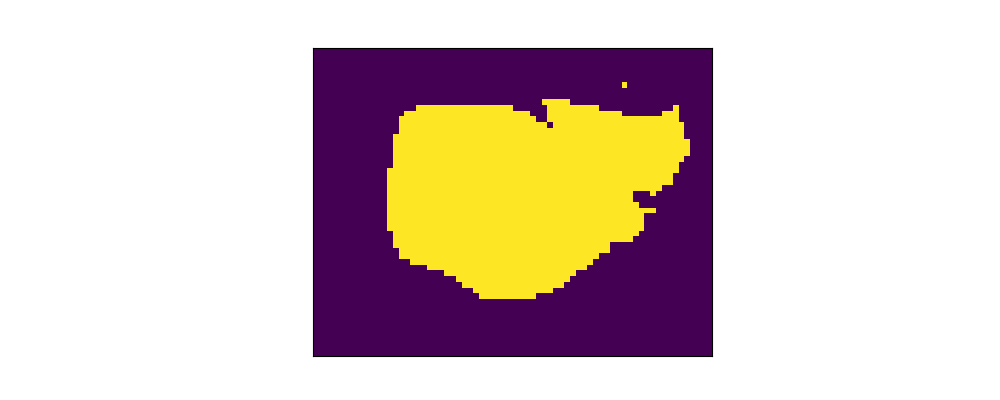

In [178]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
base=np.logical_or(top_four_intersections[0],top_four_intersections[1])
ax.imshow(base)
ax.set_xticks([])
ax.set_yticks([])

In [179]:
# para cada mineral fazer uma lista de elementos que nao pertencem
absent_elements_t=[]
for i in range(len(minerals)):
    temporary=[]
    for j in range(len(cluster_label)):
        if cluster_label[j] not in minerals[i]:
            temporary.append(cluster_label[j])
    absent_elements_t.append(temporary)

In [180]:
import pandas as pd

# Load the updated mineral composition CSV file
file_path = 'C:/Users/Joana/Documents/Doutoramento/1 ano/spectral imaging/imaging_clustering/novembro 2024/mineral_ref_rruf.csv'  # Ensure the file path matches your new database
minerals_df = pd.read_csv(file_path)

def identify_possible_minerals(present_elements, absent_elements):
    present_elements_set = set(present_elements)
    absent_elements_set = set(absent_elements)

    def matches_criteria(elements_str):
        # Updated to handle the new format with space-separated elements
        elements_set = set(elements_str.split())
        if not present_elements_set.issubset(elements_set):
            return False
        if absent_elements_set.intersection(elements_set):
            return False
        return True

    # Filter the minerals based on the matching criteria
    possible_minerals = minerals_df[minerals_df['Chemistry Elements'].apply(matches_criteria)]
    return list(possible_minerals.itertuples(index=False, name=None))

# Iterate over the `minerals` list
for i in range(len(minerals)):
    present_elements = minerals[i]
    absent_elements = absent_elements_t[i]  # Use the corresponding absent elements

    # Identify possible minerals
    possible_minerals = identify_possible_minerals(present_elements, absent_elements)

    # Display results for the current intersection
    print('\n')
    print(f"Possible minerals for: {minerals[i]}")
    for mineral, composition in possible_minerals:
        print(f"{mineral}: {composition}")




Possible minerals for: ['Al', 'Li', 'P']
Amblygonite: Li Al P O F
Bertossaite: Li Ca Al P O H
Griphite: Ca Mn Na Li Fe Al P O F H
Montebrasite: Li Al P O H
Palermoite: Li Sr Al P O H
Tancoite: Li Na Al P O H


Possible minerals for: ['Si']
Abswurmbachite: Cu Mn O Si
Actinolite: Ca Mg Fe Si O H
Aegirine: Na Fe Si O
Aegirine-augite: Ca Na Fe Mg Si O
Aenigmatite: Na Fe Ti O Si
Afwillite: Ca Si O H
Agakhanovite-(Y): Y Ca K Be Si O
Agrellite: Na Ca Si O F
Ahrensite: Si Fe O
Åkermanite: Ca Mg Si O
Akimotoite: Mg Si O
Aklimaite: Ca Si O H
Alamosite: Pb Si O
Alexkuznetsovite-(Ce): Ce Mn C O Si
Alexkuznetsovite-(La): La Mn C O Si
Alflarsenite: Na Ca Be Si O H
Alfredcasparite: Sr Ti O Si
Alleghanyite: Mn Si O H
Alluaivite: Na Ca Mn Ti Nb Si O Cl H
Alsakharovite-Zn: Na Sr K Zn Ti Nb Si O H
Alvesite: Na K Zr Si O H
Amamoorite: Ca Mn Si O H
Aminoffite: Ca Be O H Si
Anandite: Ba Fe Si O S H
Andradite: Ca Fe Si O
Andrémeyerite: Ba Fe Si O
Andrianovite: Na K Sr Ce Ca Mn Zr Nb Si O H
Anorthoyttrialit

In [181]:
import pandas as pd

# Load the updated mineral composition CSV file
file_path = 'C:/Users/Joana/Documents/Doutoramento/1 ano/spectral imaging/imaging_clustering/novembro 2024/mineral_ref_rruf.csv'
minerals_df = pd.read_csv(file_path)

# Standardize column names (replace spaces with underscores for easier access)
minerals_df.columns = minerals_df.columns.str.replace(' ', '_')

def rank_possible_minerals(present_elements, absent_elements):
    present_elements_set = set(present_elements)
    absent_elements_set = set(absent_elements)

    def calculate_score(elements_str):
        # Parse the elements of the mineral
        elements_set = set(elements_str.split())

        # Count matched elements
        matched_present = len(present_elements_set.intersection(elements_set))
        
        # Total elements in the mineral
        total_elements = len(elements_set)

        # Match ratio: proportion of detected elements in the mineral's composition
        match_ratio = matched_present / total_elements

        # Penalty for missing detected elements
        missing_detected = len(present_elements_set.difference(elements_set))
        missing_penalty = missing_detected * 0.5  # Adjust weight of penalty as needed

        # Penalty for absent elements present in the mineral
        absent_penalty = len(absent_elements_set.intersection(elements_set)) * 0.1

        # Final score: match ratio - penalties
        return match_ratio - missing_penalty - absent_penalty

    # Add a score column to the DataFrame
    minerals_df['Score'] = minerals_df['Chemistry_Elements'].apply(calculate_score)

    # Filter out minerals with non-positive scores
    filtered_df = minerals_df[minerals_df['Score'] > 0]

    # Sort minerals by score in descending order and return the top 10 results
    ranked_minerals = filtered_df.sort_values(by='Score', ascending=False)
    return ranked_minerals[['Mineral_Name', 'Chemistry_Elements', 'Score']].head(20)

# Assuming minerals and absent_elements_t are predefined lists from the first cell
# Here is how you would use them to rank the minerals:

# Iterate over the `minerals` list
for i in range(len(minerals)):
    present_elements = minerals[i]
    absent_elements = absent_elements_t[i]  # Use the corresponding absent elements

    # Rank possible minerals
    ranked_minerals = rank_possible_minerals(present_elements, absent_elements)

    # Display results for the current intersection
    print('\n')
    print(f"Ranked minerals for: {present_elements}")
    for row in ranked_minerals.itertuples(index=False):
        print(f"{row.Mineral_Name}: {row.Chemistry_Elements} (Score: {row.Score:.2f})")




Ranked minerals for: ['Al', 'Li', 'P']
Amblygonite: Li Al P O F (Score: 0.60)
Montebrasite: Li Al P O H (Score: 0.60)
Bertossaite: Li Ca Al P O H (Score: 0.50)
Palermoite: Li Sr Al P O H (Score: 0.50)
Tancoite: Li Na Al P O H (Score: 0.50)
Griphite: Ca Mn Na Li Fe Al P O F H (Score: 0.30)
Berlinite: Al P O (Score: 0.17)
Chukochenite: Li Al O (Score: 0.17)
Lithiophosphate: Li P O (Score: 0.17)


Ranked minerals for: ['Si']
Silicon: Si (Score: 1.00)
Kangjinlaite: Ti Si (Score: 0.50)
Lechatelierite: Si O (Score: 0.50)
Suessite: Fe Si (Score: 0.50)
Cristobalite: Si O (Score: 0.50)
Nierite: Si N (Score: 0.50)
Yeite: Ti Si (Score: 0.50)
Brownleeite: Mn Si (Score: 0.50)
Carletonmooreite: Ni Si (Score: 0.50)
Luobusaite: Fe Si (Score: 0.50)
Mavlyanovite: Mn Si (Score: 0.50)
Quartz: Si O (Score: 0.50)
Naquite: Fe Si (Score: 0.50)
Gupeiite: Fe Si (Score: 0.50)
Moissanite: Si C (Score: 0.50)
Xifengite: Fe Si (Score: 0.50)
Tridymite: Si O (Score: 0.50)
Seifertite: Si O (Score: 0.50)
Palladosilici

como mais de metade dos minerais têm oxigenio na sua composição adaptei para dar um score mais elevado no caso do elemento em falta ser oxigenio

fonte: https://www.rockngem.com/oxygen-and-our-mineral-world/

In [183]:
def rank_possible_minerals(present_elements, absent_elements):
    present_elements_set = set(present_elements)
    absent_elements_set = set(absent_elements)

    def calculate_score(elements_str):
        # Parse the elements of the mineral
        elements_set = set(elements_str.split())

        # Count matched elements
        matched_present = len(present_elements_set.intersection(elements_set))
        
        # Total elements in the mineral
        total_elements = len(elements_set)

        # Match ratio: proportion of detected elements in the mineral's composition
        match_ratio = matched_present / total_elements

        # Penalty for missing detected elements
        missing_detected = present_elements_set.difference(elements_set)

        # Oxygen-specific penalty (penalize missing oxygen, but less than other elements)
        oxygen_penalty = 0.25 if 'O' in missing_detected else 0
        other_missing_penalty = len(missing_detected - {'O'}) * 0.5  # Penalize other missing elements more

        # Penalty for absent elements present in the mineral
        absent_penalty = len(absent_elements_set.intersection(elements_set)) * 0.1

        # Final score: match ratio - penalties
        return match_ratio - oxygen_penalty - other_missing_penalty - absent_penalty

    # Add a score column to the DataFrame
    minerals_df['Score'] = minerals_df['Chemistry_Elements'].apply(calculate_score)

    # Filter out minerals with non-positive scores
    filtered_df = minerals_df[minerals_df['Score'] > 0]

    # Sort minerals by score in descending order and return the top 20 results
    ranked_minerals = filtered_df.sort_values(by='Score', ascending=False)
    return ranked_minerals[['Mineral_Name', 'Chemistry_Elements', 'Score']].head(20)

# Assuming minerals and absent_elements_t are predefined lists
for i in range(len(minerals)):
    present_elements = minerals[i]
    absent_elements = absent_elements_t[i]

    # Rank possible minerals
    ranked_minerals = rank_possible_minerals(present_elements, absent_elements)

    # Display results for the current intersection
    print('\n')
    print(f"Ranked minerals for: {present_elements}")
    for row in ranked_minerals.itertuples(index=False):
        print(f"{row.Mineral_Name}: {row.Chemistry_Elements} (Score: {row.Score:.2f})")




Ranked minerals for: ['Al', 'Li', 'P']
Amblygonite: Li Al P O F (Score: 0.60)
Montebrasite: Li Al P O H (Score: 0.60)
Bertossaite: Li Ca Al P O H (Score: 0.50)
Palermoite: Li Sr Al P O H (Score: 0.50)
Tancoite: Li Na Al P O H (Score: 0.50)
Griphite: Ca Mn Na Li Fe Al P O F H (Score: 0.30)
Berlinite: Al P O (Score: 0.17)
Chukochenite: Li Al O (Score: 0.17)
Lithiophosphate: Li P O (Score: 0.17)


Ranked minerals for: ['Si']
Silicon: Si (Score: 1.00)
Kangjinlaite: Ti Si (Score: 0.50)
Lechatelierite: Si O (Score: 0.50)
Suessite: Fe Si (Score: 0.50)
Cristobalite: Si O (Score: 0.50)
Nierite: Si N (Score: 0.50)
Yeite: Ti Si (Score: 0.50)
Brownleeite: Mn Si (Score: 0.50)
Carletonmooreite: Ni Si (Score: 0.50)
Luobusaite: Fe Si (Score: 0.50)
Mavlyanovite: Mn Si (Score: 0.50)
Quartz: Si O (Score: 0.50)
Naquite: Fe Si (Score: 0.50)
Gupeiite: Fe Si (Score: 0.50)
Moissanite: Si C (Score: 0.50)
Xifengite: Fe Si (Score: 0.50)
Tridymite: Si O (Score: 0.50)
Seifertite: Si O (Score: 0.50)
Palladosilici